# 🧠 Risk-Adaptive Keystone Anomaly Detection (Unsupervised)

### 📘 **Dataset**
**Name:** `communication-devstack-keystone-anomalies`  
**Files:**
- `keystone_features.csv` → raw logs  
- `keystone_features_parsed.csv` → cleaned version  
- `keystone_features_parsed_struct.csv` → ✅ final structured dataset (used here)

---

## 🗂️ Dataset Hierarchy
```markdown
📁 communication-devstack-keystone-anomalies/
│
├── keystone_features.csv
│    └─ Raw merged features
│
├── keystone_features_parsed.csv
│    └─ Cleaned, parsed intermediate data
│
├── keystone_features_parsed_struct.csv  ✅ Final ML Dataset
│    └─ Normalized numeric features for anomaly detection
│
└── parser_v1.py / praser.py
     └─ Log parsing utilities
```

---

## 🧮 Notebook Sections
1. Import & Setup  
2. Load Dataset  
3. EDA (plots, correlations)  
4. Unsupervised Models (Isolation Forest, LOF, OC-SVM)  
5. Results Visualization  
6. Save Outputs  


### 🧩 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted")

### 📥 2. Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/communication-devstack-dataset/keystone_features_parsed_struct.csv")
print("✅ Loaded successfully! Shape:", df.shape)
df.head()

✅ Loaded successfully! Shape: (222308, 17)


,process_id,application_number,request_sequence,src_ip,num_vars,vars_size_bytes,timestamp,method,path,response_size_bytes,processing_time_ms,http_version,status,num_headers,headers_size_bytes,core_switches,core_number
0,30439,0,1/1,10.0.2.15,48,751,Tue Sep 30 14:25:23 2025,GET,/identity/v3/,253,5,1.1,200,5,177,1,0
1,30439,0,2/2,10.0.2.15,52,887,Tue Sep 30 14:25:26 2025,GET,/identity,268,1,1.1,300,6,232,1,0
2,30438,0,1/3,10.0.2.15,56,984,Tue Sep 30 14:25:26 2025,POST,/identity/v3/auth/tokens,975,127,1.1,201,6,384,1,0
3,30439,0,3/4,10.0.2.15,56,1284,Tue Sep 30 14:25:27 2025,GET,/identity/v3/auth/tokens,975,63,1.1,200,6,379,1,0
4,30438,0,2/5,10.0.2.15,54,1167,Tue Sep 30 14:25:27 2025,GET,/identity/v3/projects/8fa0b0ac760c4b77b7016070...,342,14,1.1,200,5,177,1,0


### 📊 3. Quick EDA

,count,mean,std,min,25%,50%,75%,max
process_id,222308.000000,43807.934721,523.380588,30438.000000,43828.000000,43828.000000,43829.000000,43829.000000
application_number,222308.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
num_vars,222308.000000,56.461045,0.855520,48.000000,56.000000,56.000000,56.000000,58.000000
vars_size_bytes,222308.000000,923.373810,19.202234,751.000000,915.000000,915.000000,915.000000,1467.000000
response_size_bytes,222308.000000,111.422495,69.997294,0.000000,109.000000,109.000000,109.000000,3519.000000
processing_time_ms,222308.000000,11.508196,5.971467,0.000000,6.000000,13.000000,15.000000,174.000000
http_version,222308.000000,1.100000,0.000000,1.100000,1.100000,1.100000,1.100000,1.100000
status,222308.000000,400.540624,9.421549,200.000000,401.000000,401.000000,401.000000,409.000000
num_headers,222308.000000,5.997796,0.053104,3.000000,6.000000,6.000000,6.000000,6.000000
headers_size_bytes,222308.000000,249.884539,3.981990,132.000000,250.000000,250.000000,250.000000,384.000000


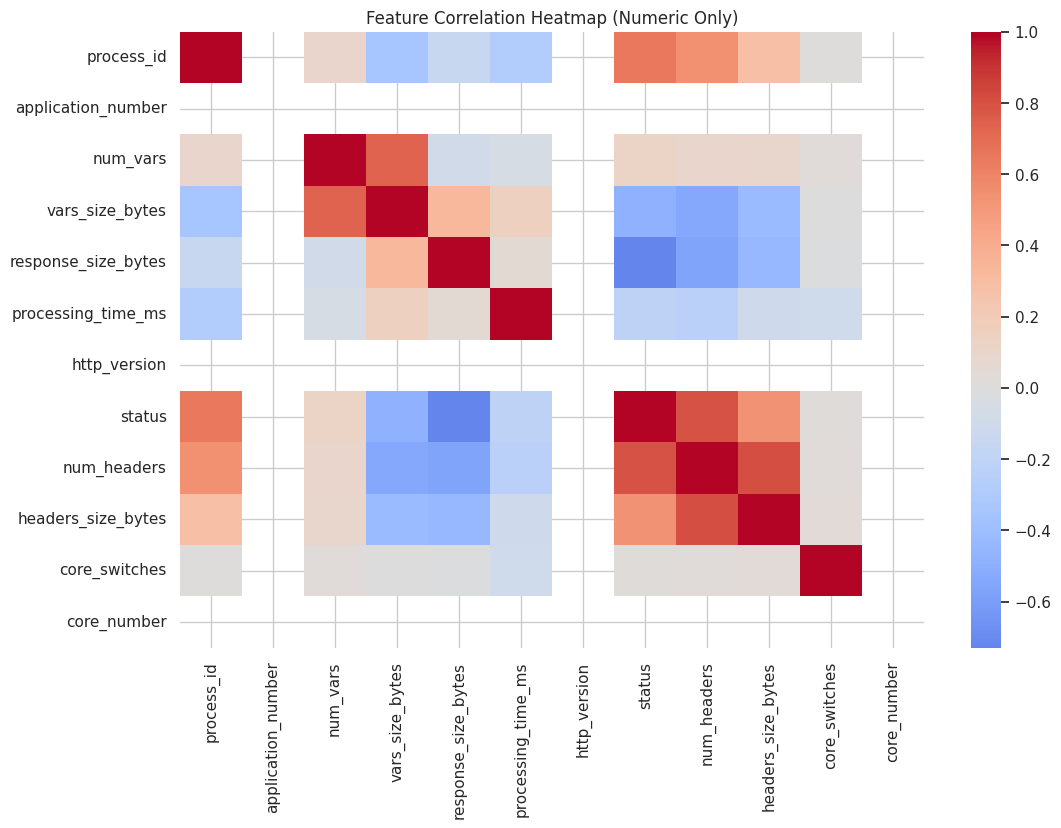

In [3]:
# --- FIXED EDA SECTION ---
# Describe only numeric features
numeric_df = df.select_dtypes(include=[np.number])
display(numeric_df.describe().T.style.background_gradient(cmap="Blues"))

# Correlation heatmap for numeric columns only
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Numeric Only)")
plt.show()


### 📈 4. Key Feature Visuals

In [4]:
print(df.columns.tolist())


['process_id', 'application_number', 'request_sequence', 'src_ip', 'num_vars', 'vars_size_bytes', 'timestamp', 'method', 'path', 'response_size_bytes', 'processing_time_ms', 'http_version', 'status', 'num_headers', 'headers_size_bytes', 'core_switches', 'core_number']


### ⚙️ 5. Scale Features

In [5]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))
print("✅ Features scaled and ready for modeling")

✅ Features scaled and ready for modeling


### 💾 10. Save Output

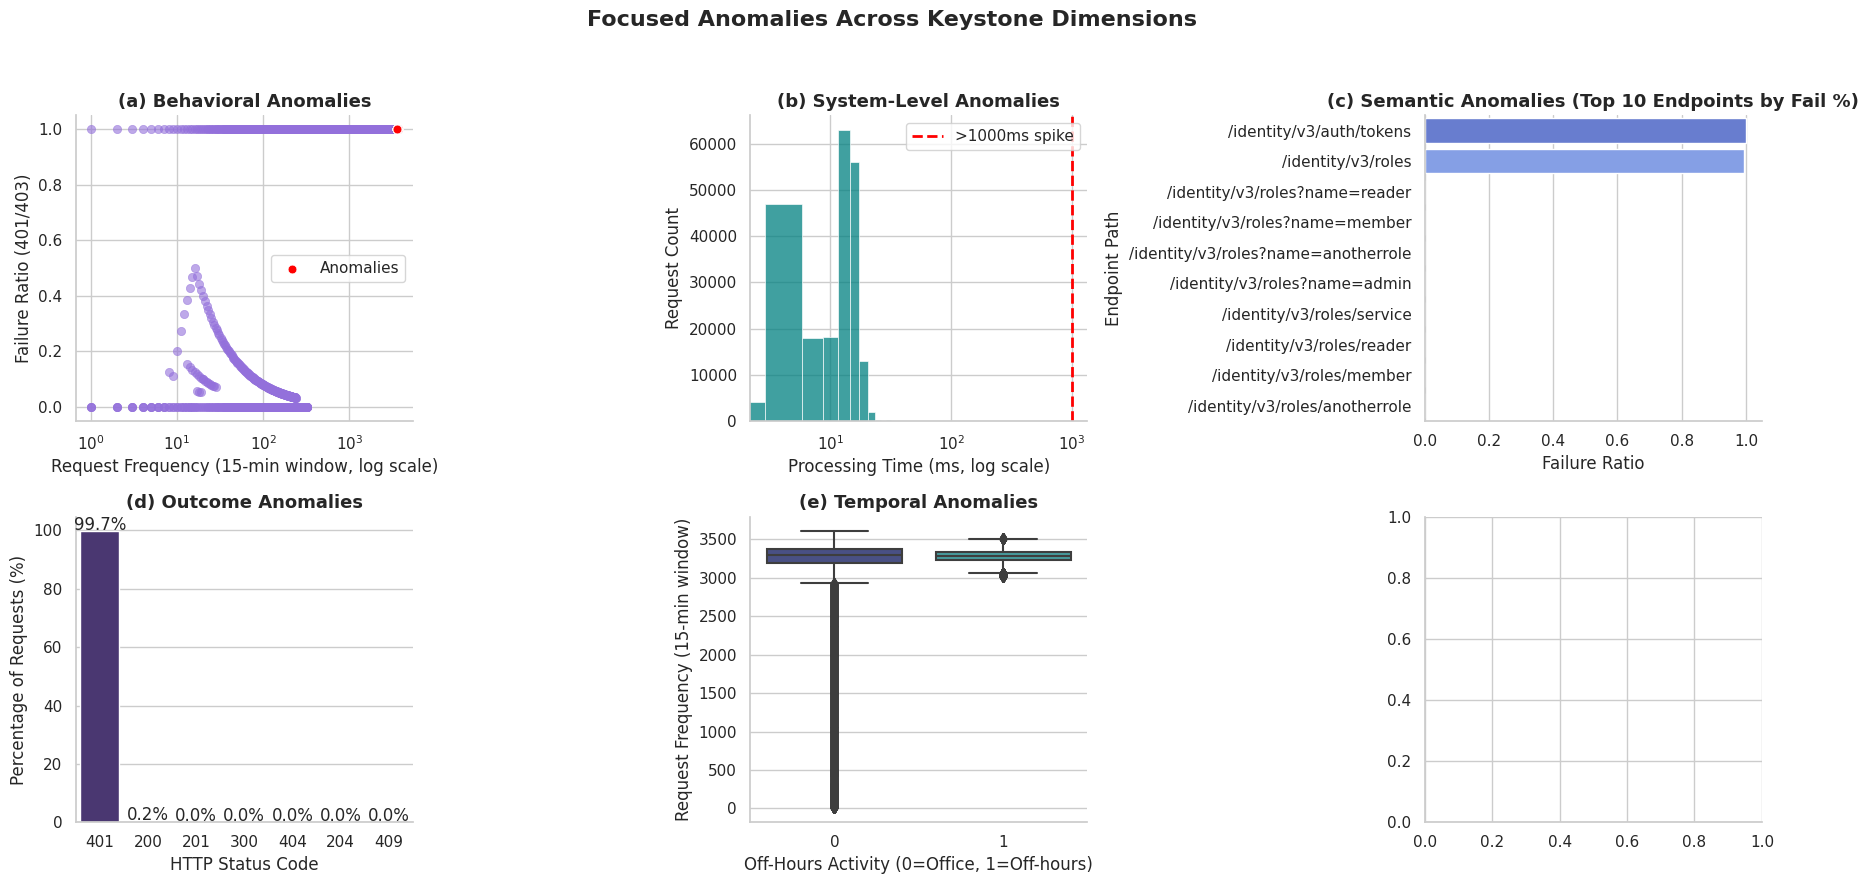

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Load dataset ---
df = pd.read_csv("/kaggle/input/communication-devstack-dataset/keystone_features_parsed_struct.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['wday'] = df['timestamp'].dt.day_name()
df['is_off_hours'] = ((df['hour'] < 8) | (df['hour'] > 18)).astype(int)
df = df.sort_values(['src_ip', 'timestamp']).reset_index(drop=True)

# --- Compute rolling features ---
def compute_behavioral_features(group):
    group = group.sort_values('timestamp').set_index('timestamp')
    group['freq15_user'] = group['src_ip'].rolling('15min').count()
    group['fail'] = group['status'].isin([401, 403]).astype(int)
    group['fail_ratio_user15'] = group['fail'].rolling('15min').mean()
    group.reset_index(inplace=True)
    group.drop(columns='fail', inplace=True)
    return group

df = df.groupby('src_ip', group_keys=False).apply(compute_behavioral_features)

# --- Clean out NaNs ---
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['freq15_user', 'fail_ratio_user15', 'processing_time_ms'])

# --- Figure setup ---
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

fig, axs = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle("Focused Anomalies Across Keystone Dimensions", fontsize=16, fontweight='bold')

# --- (a) Behavioral anomalies (log-scale) ---
sns.scatterplot(
    x='freq15_user', y='fail_ratio_user15', data=df,
    ax=axs[0,0], color='mediumpurple', alpha=0.6, edgecolor=None
)
axs[0,0].set_title("(a) Behavioral Anomalies", fontweight='semibold')
axs[0,0].set_xlabel("Request Frequency (15-min window, log scale)")
axs[0,0].set_ylabel("Failure Ratio (401/403)")
axs[0,0].set_xscale('log')
sns.scatterplot(
    x='freq15_user', y='fail_ratio_user15',
    data=df[df['freq15_user'] > df['freq15_user'].quantile(0.99)],
    ax=axs[0,0], color='red', s=40, label='Anomalies'
)
axs[0,0].legend(frameon=True)

# --- (b) System-level anomalies (log-scale) ---
sns.histplot(df['processing_time_ms'], bins=60, ax=axs[0,1], color='teal')
axs[0,1].set_xscale('log')
axs[0,1].axvline(1000, color='red', linestyle='--', lw=2, label='>1000ms spike')
axs[0,1].set_title("(b) System-Level Anomalies", fontweight='semibold')
axs[0,1].set_xlabel("Processing Time (ms, log scale)")
axs[0,1].set_ylabel("Request Count")
axs[0,1].legend(frameon=True)

# --- (c) Semantic anomalies (top endpoints by failure ratio if endpoint_class missing) ---
if 'endpoint_class' in df.columns:
    order = df['endpoint_class'].value_counts().index
    sns.boxplot(
        x='endpoint_class', y='fail_ratio_user15', data=df,
        ax=axs[0,2], order=order, palette='coolwarm'
    )
    axs[0,2].set_title("(c) Semantic Anomalies", fontweight='semibold')
    axs[0,2].set_xlabel("Endpoint Class")
    axs[0,2].set_ylabel("Failure Ratio (401/403)")
    axs[0,2].tick_params(axis='x', rotation=30)
else:
    top_endpoints = (
        df.groupby('path')['status']
        .apply(lambda s: (s.isin([401,403]).mean()))
        .sort_values(ascending=False)
        .head(10)
    )
    sns.barplot(x=top_endpoints.values, y=top_endpoints.index, ax=axs[0,2], palette='coolwarm')
    axs[0,2].set_title("(c) Semantic Anomalies (Top 10 Endpoints by Fail %)", fontweight='semibold')
    axs[0,2].set_xlabel("Failure Ratio")
    axs[0,2].set_ylabel("Endpoint Path")

# --- (d) Outcome anomalies ---
normal = df['status'].value_counts(normalize=True) * 100
sns.barplot(x=normal.index.astype(str), y=normal.values, ax=axs[1,0], palette='viridis')
axs[1,0].set_title("(d) Outcome Anomalies", fontweight='semibold')
axs[1,0].set_xlabel("HTTP Status Code")
axs[1,0].set_ylabel("Percentage of Requests (%)")
for p in axs[1,0].patches:
    height = p.get_height()
    axs[1,0].text(p.get_x() + p.get_width()/2., height + 0.5, f'{height:.1f}%', ha="center")

# --- (e) Temporal anomalies ---
sns.boxplot(
    x='is_off_hours', y='freq15_user', data=df,
    ax=axs[1,1], palette='mako'
)
axs[1,1].set_title("(e) Temporal Anomalies", fontweight='semibold')
axs[1,1].set_xlabel("Off-Hours Activity (0=Office, 1=Off-hours)")
axs[1,1].set_ylabel("Request Frequency (15-min window)")


plt.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()
plt.show()


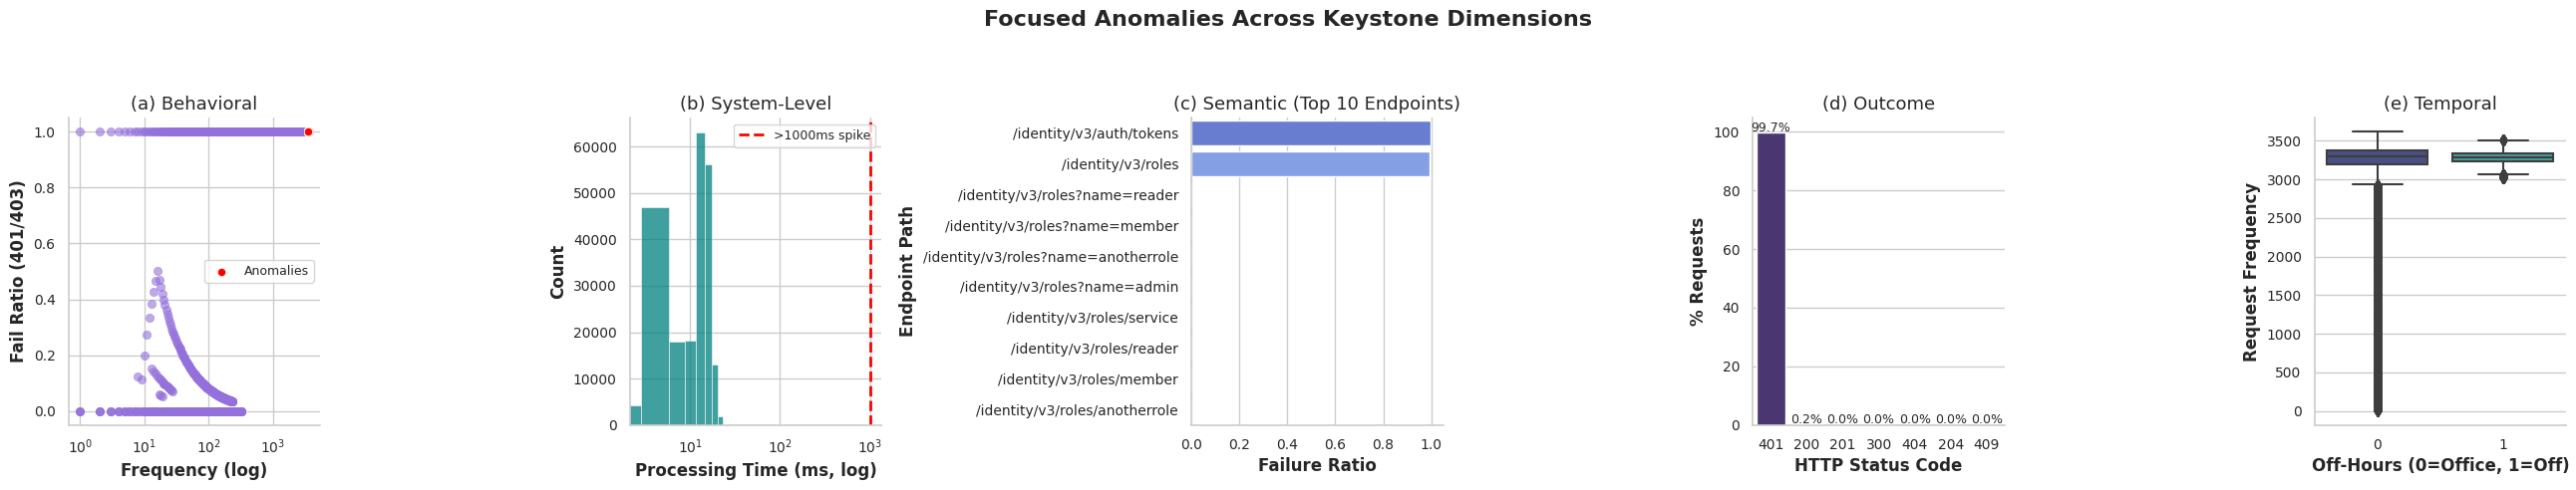

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Load dataset ---
df = pd.read_csv("/kaggle/input/communication-devstack-dataset/keystone_features_parsed_struct.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['wday'] = df['timestamp'].dt.day_name()
df['is_off_hours'] = ((df['hour'] < 8) | (df['hour'] > 18)).astype(int)
df = df.sort_values(['src_ip', 'timestamp']).reset_index(drop=True)

# --- Compute rolling features per user/IP ---
def compute_behavioral_features(group):
    group = group.sort_values('timestamp').set_index('timestamp')
    group['freq15_user'] = group['src_ip'].rolling('15min').count()
    group['fail'] = group['status'].isin([401, 403]).astype(int)
    group['fail_ratio_user15'] = group['fail'].rolling('15min').mean()
    group.reset_index(inplace=True)
    group.drop(columns='fail', inplace=True)
    return group

df = df.groupby('src_ip', group_keys=False).apply(compute_behavioral_features)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['freq15_user', 'fail_ratio_user15', 'processing_time_ms'])

# --- Figure setup ---
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

fig, axs = plt.subplots(1, 5, figsize=(26, 5))
fig.suptitle("Focused Anomalies Across Keystone Dimensions", fontsize=16, fontweight='bold')

# --- (a) Behavioral anomalies ---
sns.scatterplot(
    x='freq15_user', y='fail_ratio_user15', data=df,
    ax=axs[0], color='mediumpurple', alpha=0.6, edgecolor=None
)
axs[0].set_title("(a) Behavioral")
axs[0].set_xlabel("Frequency (log)")
axs[0].set_ylabel("Fail Ratio (401/403)")
axs[0].set_xscale('log')
sns.scatterplot(
    x='freq15_user', y='fail_ratio_user15',
    data=df[df['freq15_user'] > df['freq15_user'].quantile(0.99)],
    ax=axs[0], color='red', s=35, label='Anomalies'
)
axs[0].legend(frameon=True, fontsize=9)

# --- (b) System-level anomalies ---
sns.histplot(df['processing_time_ms'], bins=60, ax=axs[1], color='teal')
axs[1].axvline(1000, color='red', linestyle='--', lw=2, label='>1000ms spike')
axs[1].set_title("(b) System-Level")
axs[1].set_xlabel("Processing Time (ms, log)")
axs[1].set_ylabel("Count")
axs[1].set_xscale('log')
axs[1].legend(frameon=True, fontsize=9)

# --- (c) Semantic anomalies ---
if 'endpoint_class' in df.columns:
    order = df['endpoint_class'].value_counts().index
    sns.boxplot(x='endpoint_class', y='fail_ratio_user15', data=df,
                ax=axs[2], order=order, palette='coolwarm')
    axs[2].set_title("(c) Semantic")
    axs[2].set_xlabel("Endpoint Class")
    axs[2].set_ylabel("Fail Ratio")
    axs[2].tick_params(axis='x', rotation=30)
else:
    top_endpoints = (
        df.groupby('path')['status']
        .apply(lambda s: (s.isin([401,403]).mean()))
        .sort_values(ascending=False)
        .head(10)
    )
    sns.barplot(x=top_endpoints.values, y=top_endpoints.index, ax=axs[2], palette='coolwarm')
    axs[2].set_title("(c) Semantic (Top 10 Endpoints)")
    axs[2].set_xlabel("Failure Ratio")
    axs[2].set_ylabel("Endpoint Path")

# --- (d) Outcome anomalies ---
normal = df['status'].value_counts(normalize=True) * 100
sns.barplot(x=normal.index.astype(str), y=normal.values, ax=axs[3], palette='viridis')
axs[3].set_title("(d) Outcome")
axs[3].set_xlabel("HTTP Status Code")
axs[3].set_ylabel("% Requests")
for p in axs[3].patches:
    height = p.get_height()
    axs[3].text(p.get_x() + p.get_width()/2., height + 0.5, f'{height:.1f}%', ha="center", fontsize=9)

# --- (e) Temporal anomalies ---
sns.boxplot(x='is_off_hours', y='freq15_user', data=df, ax=axs[4], palette='mako')
axs[4].set_title("(e) Temporal")
axs[4].set_xlabel("Off-Hours (0=Office, 1=Off)")
axs[4].set_ylabel("Request Frequency")

# --- Layout + Export ---
plt.tight_layout(rect=[0, 0, 1, 0.92])
sns.despine()
plt.savefig("keystone_focused_anomalies_1x5.png", dpi=300, bbox_inches='tight')
plt.show()
